In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import preprocessing

In [4]:
def get_rms(records, multi_channels):
    if multi_channels == 1:
        n = records.shape[0]
        rms = 0
        for i in range(n):
            rms_t = np.sum([records[i]**2]/len(records[i]))
            rms += rms_t
        return rms/n
    
    if multi_channels == 0:
        rms = np.sum([records**2])/ len(records)
        return rms

def snr(signal, noisy):
    snr = 10 * np.log10(signal/noisy)
    return snr

In [9]:
def random_signal(signal, comb):
    res = []

    for i in range(comb):
        rand_num = np.random.permutation(signal.shape[0])
        shuffled_dataset = signal[rand_num, :]
        shuffled_dataset = shuffled_dataset.reshape(signal.shape[0], signal.shape[1])
        res.append(shuffled_dataset)
    
    random_result = np.array(res)

    return random_result

In [30]:
def prepare_data(comb):
    eeg_data = np.load('./data/EEG_all_epochs.npy')
    noise_data = np.load('./data/EMG_all_epochs.npy')

    eeg_random = np.squeeze(random_signal(signal=eeg_data, comb=1))
    noise_random = np.squeeze(random_signal(signal=noise_data, comb=1))

    reuse_num = noise_random.shape[0] - eeg_random.shape[0]
    eeg_reuse = eeg_random[0: reuse_num, :]
    eeg_random = np.vstack([eeg_reuse, eeg_random])
    print(f'EEG shape after crop and resuse to match EMG samples: {eeg_random.shape[0]}')

    t = noise_random.shape[1]
    train_num = round(eeg_random.shape[0] * 0.8)
    test_num = round(eeg_random.shape[0] - train_num)

    train_eeg = eeg_random[0: train_num, :]
    test_eeg = eeg_random[train_num: train_num + test_num,:]

    train_noise = noise_random[0: train_num, :]
    test_noise = noise_random[train_num: train_num+test_num, :]

    EEG_train = random_signal(signal=train_eeg, comb=comb).reshape(comb * train_eeg.shape[0],t)
    NOISE_train = random_signal(signal=train_noise, comb=comb).reshape(comb * train_noise.shape[0], t)

    EEG_test = random_signal(signal=test_eeg, comb=comb).reshape(comb * test_eeg.shape[0],t)
    NOISE_test = random_signal(signal=test_noise, comb=comb).reshape(comb * test_noise.shape[0], t)

    print(f"train data clean shape: {EEG_train.shape}")
    print(f"train data noise shape: {NOISE_train.shape}")

    sn_train = []
    eeg_train = []
    all_sn_test = []
    all_eeg_test = []

    SNR_train_dB = np.random.uniform(-5.0, 5.0, (EEG_train.shape[0]))
    print(SNR_train_dB.shape)
    SNR_train = np.sqrt(10**(0.1*(SNR_train_dB)))


    for i in range(EEG_train.shape[0]):
        noise = preprocessing.scale(NOISE_train[i])
        EEG = preprocessing.scale(EEG_train[i])

        alpha = get_rms(EEG, 0) / (get_rms(noise, 0 ) * SNR_train[i])
        noise *= alpha
        signal_noise = EEG + noise

        sn_train.append(signal_noise)
        eeg_train.append(EEG)
    
    SNR_test_dB = np.linspace(-5.0, 5.0, num=(11))
    SNR_test = np.sqrt(10 ** (0.1 * SNR_test_dB))

    for i in range(11):
        sn_test = []
        eeg_test = []
        for k in range(EEG_test.shape[0]):
            noise = preprocessing.scale(NOISE_test[k])
            EEG = preprocessing.scale(EEG_test[k])

            alpha = get_rms(EEG,0) / (get_rms(noise, 0) * SNR_test[i])
            noise *= alpha
            signal_noise = EEG + noise

            sn_test.append(signal_noise)
            eeg_test.append(EEG)
        
        sn_test = np.array(sn_test)
        eeg_test = np.array(eeg_test)

        all_sn_test.append(sn_test)
        all_eeg_test.append(eeg_test)
    
    X_train = np.array(sn_train)
    y_train = np.array(eeg_train)

    X_test = np.array(all_sn_test)
    y_test = np.array(all_eeg_test)

    X_train = np.expand_dims(X_train, axis=1)
    y_train = np.expand_dims(y_train, axis=1)

    X_test = np.expand_dims(X_test, axis=2)
    y_test = np.expand_dims(y_test, axis=2)

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

    return [X_train, y_train, X_test, y_test]

X_train, y_train, X_test, y_test = prepare_data(11)

EEG shape after crop and resuse to match EMG samples: 5598
train data clean shape: (49258, 512)
train data noise shape: (49258, 512)
(49258,)
(49258, 1, 512) (49258, 1, 512)
(11, 12320, 1, 512) (11, 12320, 1, 512)


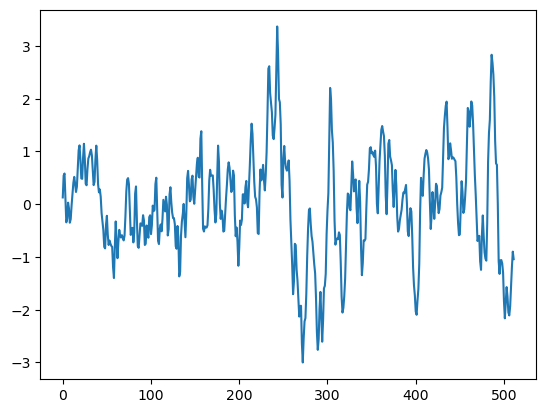

In [31]:
sig = y_train[0,0]
plt.plot(sig)

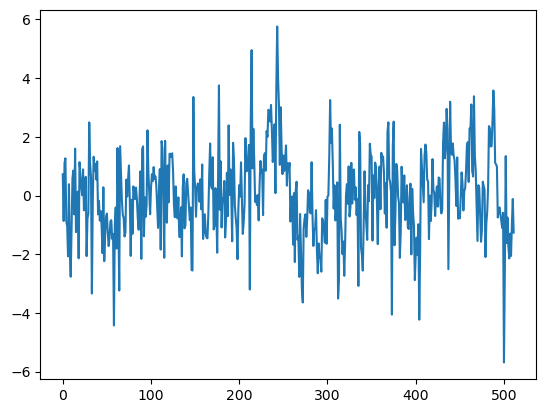

In [32]:
mix = X_train[0,0]
plt.plot(mix)

In [33]:
noise_estimate = mix - sig
snr_lin = (np.mean(sig **2)) /( np.mean(noise_estimate **2))
print('SNR db ~', 10 * np.log10(snr_lin))

SNR db ~ -0.9266932490298958
